In [30]:
pip install photutils

Note: you may need to restart the kernel to use updated packages.


In [31]:
pip install scikit-image

Note: you may need to restart the kernel to use updated packages.


In [32]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import photutils
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, aperture_photometry
from astropy.visualization import ImageNormalize, AsinhStretch  

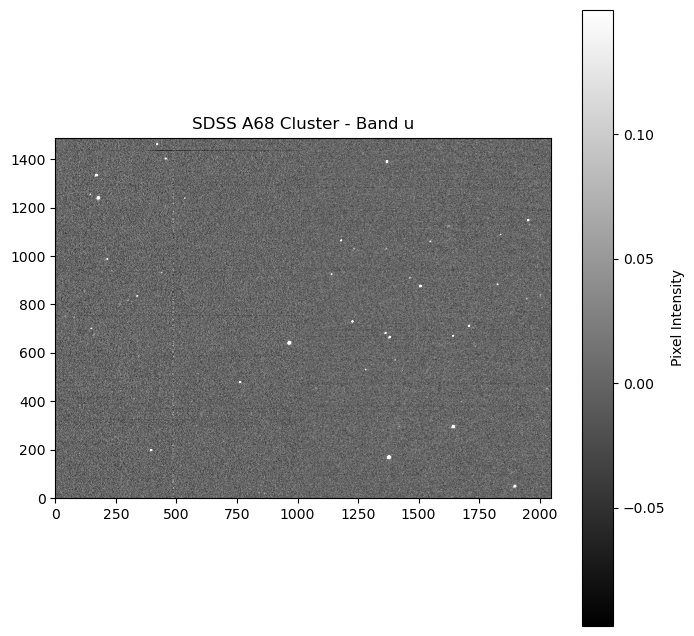

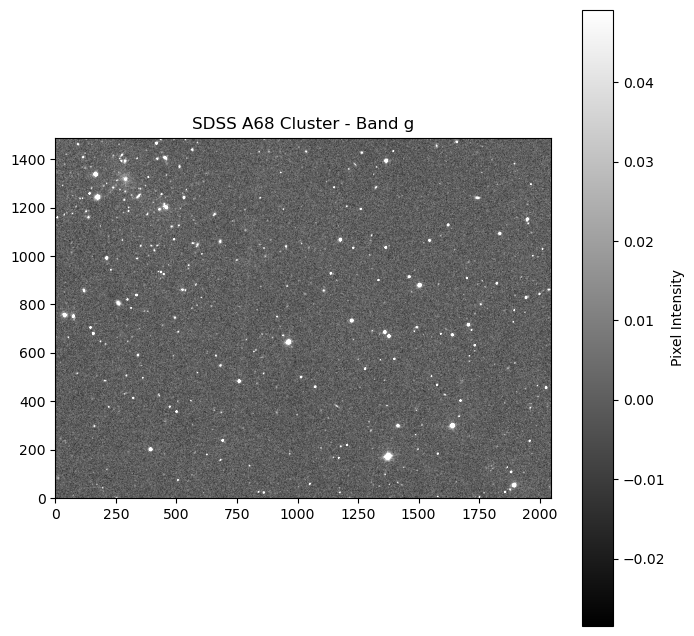

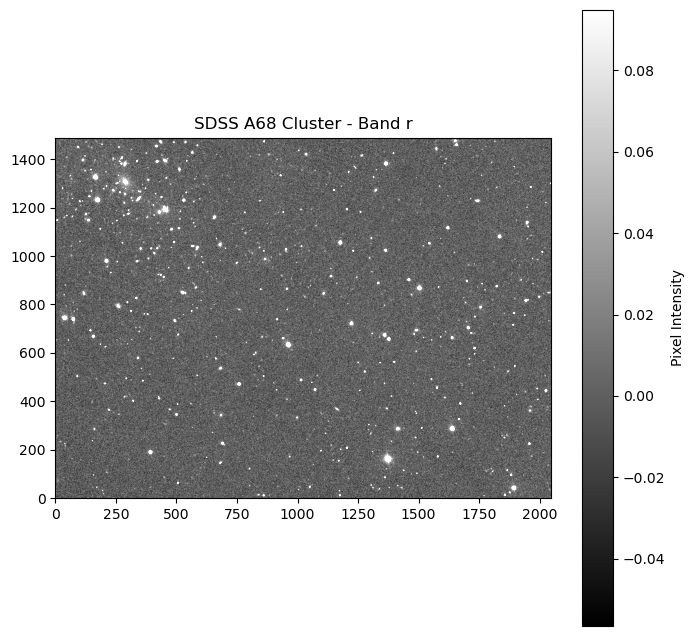

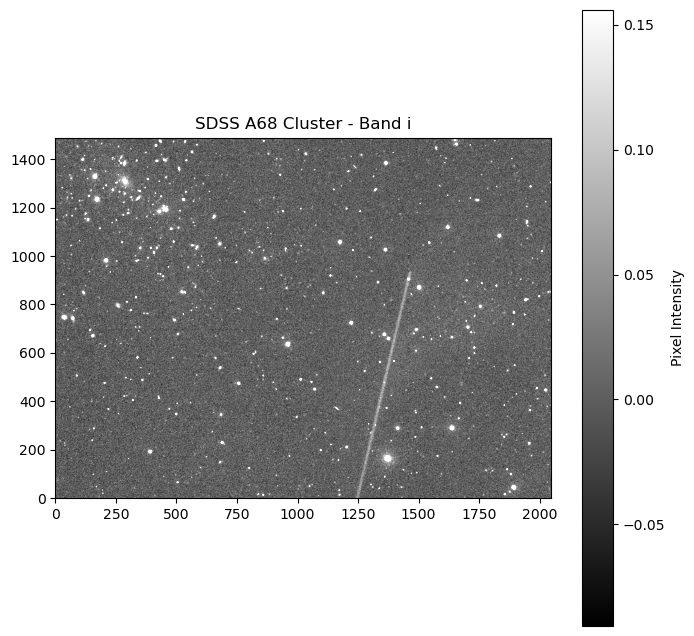

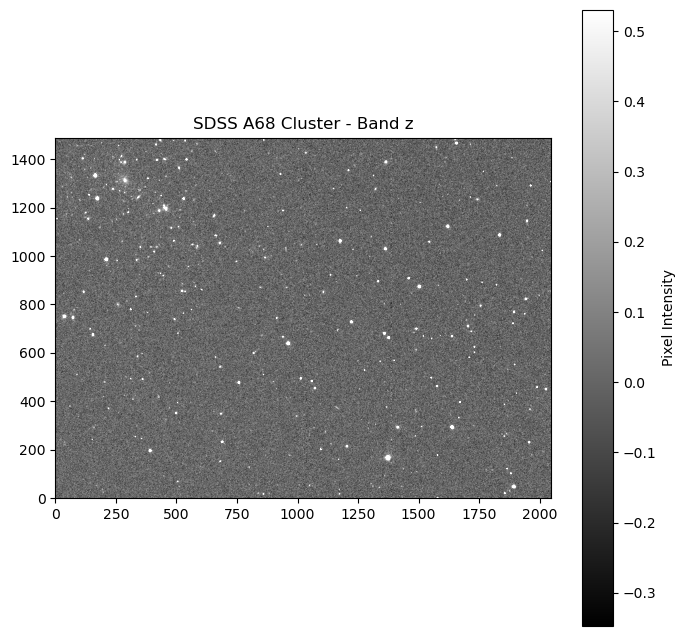

In [33]:
def load_fits_data(filename):
    with fits.open(filename) as hdul:
        return hdul[0].data

def plot_fits(image_data, band, vmin=5, vmax=99):
    plt.figure(figsize=(8, 8))
    plt.imshow(image_data, cmap='gray', origin='lower',
               vmin=np.percentile(image_data, vmin),
               vmax=np.percentile(image_data, vmax))
    plt.colorbar(label='Pixel Intensity')
    plt.title(f"SDSS A68 Cluster - Band {band}")
    plt.show()

# Load each band
bands = ['u', 'g', 'r', 'i', 'z']
data = {band: load_fits_data(f'data/frame-{band}-007784-2-0257.fits') for band in bands} # Important to add "data/" to the path 

# Visualize
for band in bands:
    plot_fits(data[band], band)


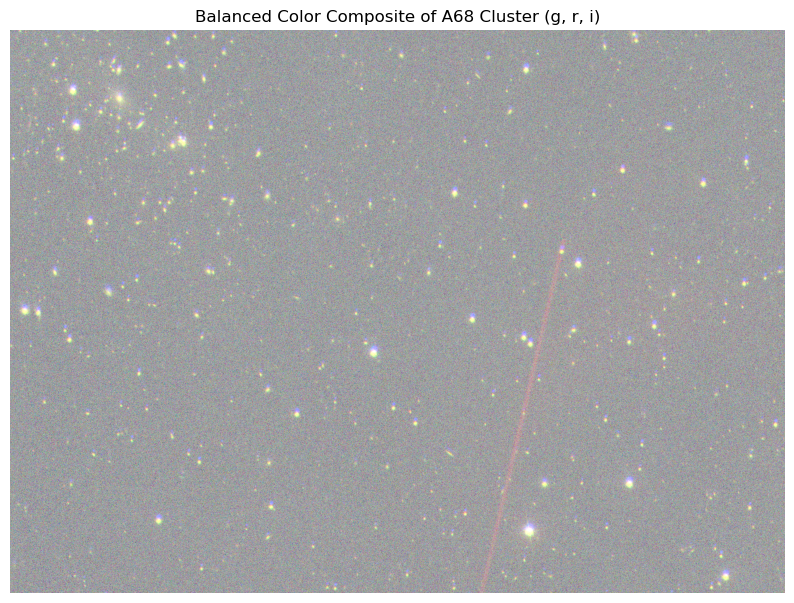

In [34]:
from astropy.visualization import ZScaleInterval, AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize

def normalize_band(data):
    interval = ZScaleInterval()
    vmin, vmax = interval.get_limits(data)
    norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch())
    return norm(data)

g_data = load_fits_data('data/frame-g-007784-2-0257.fits')
r_data = load_fits_data('data/frame-r-007784-2-0257.fits')
i_data = load_fits_data('data/frame-i-007784-2-0257.fits')

# Apply to each band
r_norm = normalize_band(r_data)
g_norm = normalize_band(g_data)
i_norm = normalize_band(i_data)

# Stack into RGB image (i = red, r = green, g = blue)
rgb = np.dstack((i_norm, r_norm, g_norm))

# Clip to valid range
rgb = np.clip(rgb, 0, 1)

# Plot it
plt.figure(figsize=(10, 10))
plt.imshow(rgb, origin='lower')
plt.title("Balanced Color Composite of A68 Cluster (g, r, i)")
plt.axis('off')
plt.show()


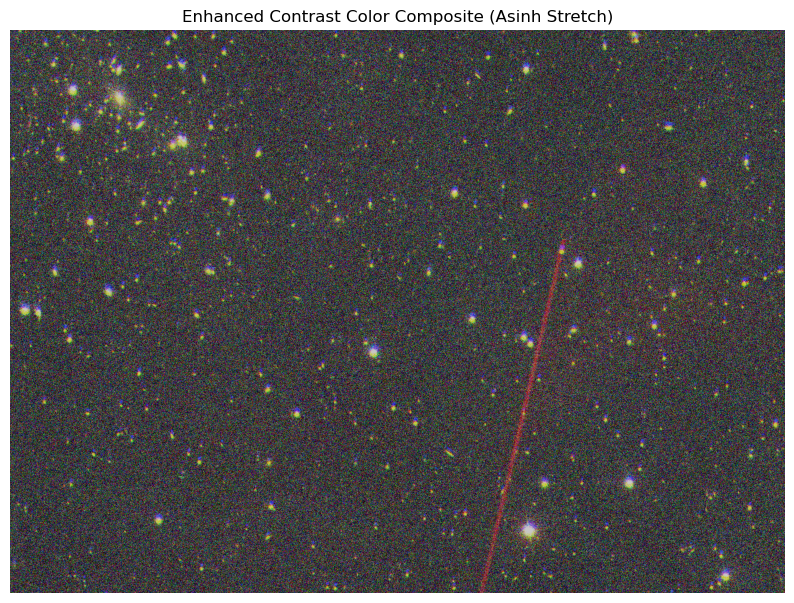

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from skimage.exposure import rescale_intensity

def load_fits_data(filename):
    with fits.open(filename) as hdul:
        return hdul[0].data.astype(np.float32)

def stretch_asinh(image, scale=10, Q=5):
    """Asinh stretch with scale and Q parameters (Lupton-style)"""
    stretched = np.arcsinh(Q * image / scale) / Q
    return stretched

def normalize_band(image, scale=10, Q=5):
    # Clip extreme values for stretch scaling
    clip_limit = np.percentile(image, 99)
    image = np.clip(image, 0, clip_limit)
    image /= clip_limit  # scale to 0–1
    return stretch_asinh(image, scale=scale, Q=Q)

# Load g, r, i bands
g = load_fits_data('data/frame-g-007784-2-0257.fits')
r = load_fits_data('data/frame-r-007784-2-0257.fits')
i = load_fits_data('data/frame-i-007784-2-0257.fits')

# Normalize and stretch for RGB
R = normalize_band(i, scale=0.2, Q=5)
G = normalize_band(r, scale=0.2, Q=5)
B = normalize_band(g, scale=0.2, Q=5)

# Rescale to 0–1
R = rescale_intensity(R, in_range=(0, 1), out_range=(0, 1))
G = rescale_intensity(G, in_range=(0, 1), out_range=(0, 1))
B = rescale_intensity(B, in_range=(0, 1), out_range=(0, 1))

# Stack and plot
rgb = np.dstack((R, G, B))
plt.figure(figsize=(10, 10))
plt.imshow(rgb, origin='lower')
plt.title("Enhanced Contrast Color Composite (Asinh Stretch)")
plt.axis('off')
plt.show()


Detected 318 sources.


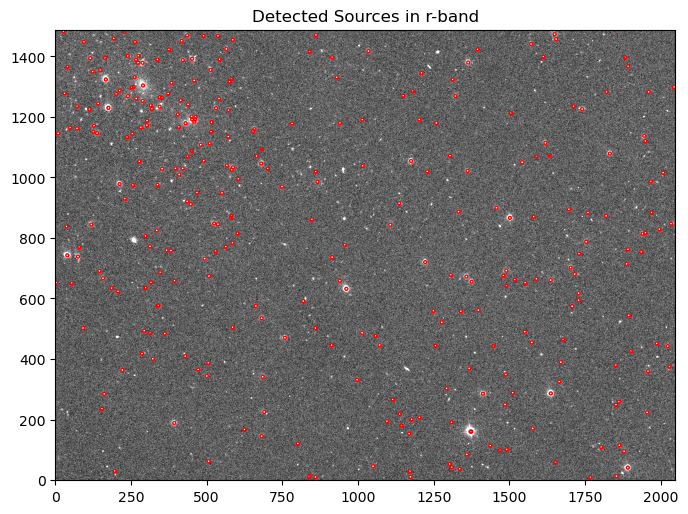

Flux density (pixel sum) of first source: 2.0825136088138727


In [36]:
with fits.open('data/frame-r-007784-2-0257.fits') as hdul:
    image_data = hdul[0].data.astype(float)

# Step 2: Estimate background
mean, median, std = sigma_clipped_stats(image_data, sigma=3.0)

# Step 3: Detect sources
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
sources = daofind(image_data - median)

print(f"Detected {len(sources)} sources.")

# Step 4: Select a source
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=5.0)

# Step 5: Plot detected sources
plt.figure(figsize=(8, 8))
plt.imshow(image_data, cmap='gray', origin='lower', vmin=np.percentile(image_data, 5), vmax=np.percentile(image_data, 99))
apertures.plot(color='red', lw=1)
plt.title('Detected Sources in r-band')
plt.show()

# Step 6: Extract flux for first source
single_aperture = CircularAperture(positions[0], r=5.0)
phot_table = aperture_photometry(image_data, single_aperture)

flux = phot_table['aperture_sum'][0]
print(f"Flux density (pixel sum) of first source: {flux}")

961.2081628457288 631.8924039577129


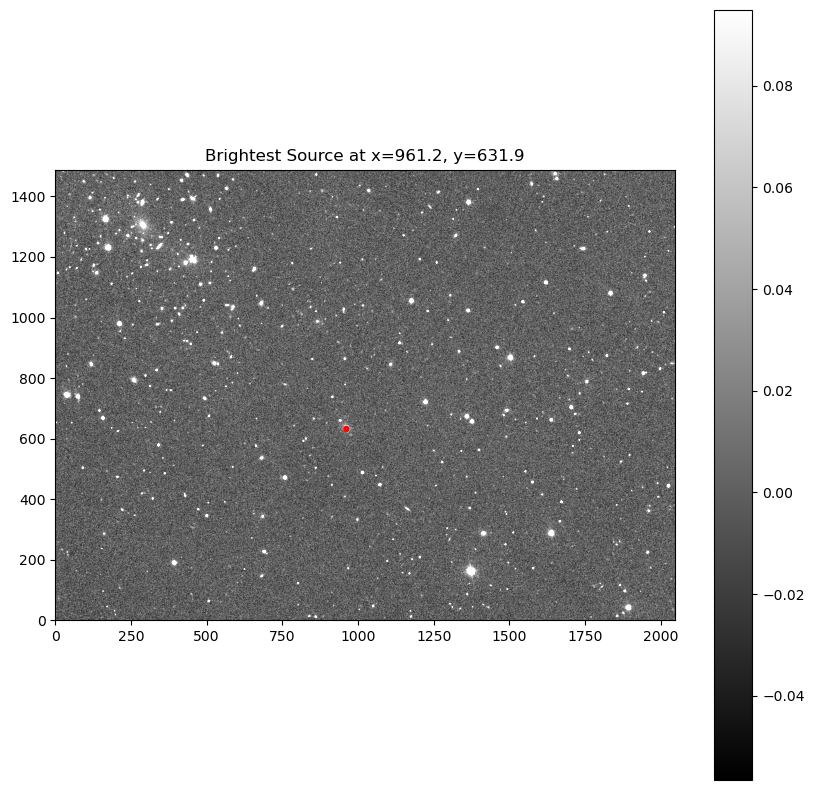

Raw flux (aperture sum): 1231.13 counts


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, aperture_photometry

# --- Load image ---
filename = 'data/frame-r-007784-2-0257.fits'
with fits.open(filename) as hdul:
    image_data = hdul[0].data.astype(float)

# --- Background estimation ---
mean, median, std = sigma_clipped_stats(image_data, sigma=3.0)

# --- Detect sources ---
daofind = DAOStarFinder(fwhm=3.0, threshold=5. * std)
sources = daofind(image_data - median)

# --- Sort by brightness (peak pixel value) ---
sources.sort('peak')
brightest = sources[-1]  # Get the brightest one

x, y = brightest['xcentroid'], brightest['ycentroid']
position = [x, y]
print(position[0],position[1])
aperture = CircularAperture(position, r=6.0)

# --- Visualize ---
plt.figure(figsize=(10, 10))
plt.imshow(image_data, cmap='gray', origin='lower',
           vmin=np.percentile(image_data, 5),
           vmax=np.percentile(image_data, 99))
aperture.plot(color='red', lw=2)
plt.title(f"Brightest Source at x={x:.1f}, y={y:.1f}")
plt.colorbar()
plt.show()

# --- Photometry ---
phot_table = aperture_photometry(image_data, aperture)
flux = phot_table['aperture_sum'][0]
print(f"Raw flux (aperture sum): {flux:.2f} counts")


In [39]:
x, y = int(round(position[0])), int(round(position[1]))
raw_counts = image_data[y, x]  # Note: y first, then x (row, column)
print(f"Raw counts at pixel ({x},{y}): {raw_counts}")
aperture_radius = 5  # pixels, adjust based on source size

apertures = CircularAperture(position, r=aperture_radius)
phot_table = aperture_photometry(image_data, apertures)

print(phot_table)

Raw counts at pixel (961,632): 154.25
 id      xcenter           ycenter         aperture_sum   
--- ----------------- ----------------- ------------------
  1 961.2081628457288 631.8924039577129 1205.7417572705917


In [40]:
from astropy.io import fits
from astropy.wcs import WCS
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
import numpy as np

def measure_flux(fits_file, position, aperture_radius=5, annulus_r_in=8, annulus_r_out=12):
    # Load FITS data
    with fits.open(fits_file) as hdul:
        image_data = hdul[0].data
        header = hdul[0].header

    # Photometric calibration factor (from SDSS header)
    nMgy_per_count = header.get('NMGY')
    if nMgy_per_count is None:
        raise ValueError("NMGY keyword not found in header.")

    # Define source and background apertures
    aperture = CircularAperture(position, r=aperture_radius)
    annulus = CircularAnnulus(position, r_in=annulus_r_in, r_out=annulus_r_out)

    # Perform aperture photometry
    aper_stats = aperture_photometry(image_data, [aperture, annulus])

    raw_flux = aper_stats['aperture_sum_0'][0]
    bkg_flux = aper_stats['aperture_sum_1'][0]

    # Background correction
    annulus_area = annulus.area
    aperture_area = aperture.area
    bkg_mean = bkg_flux / annulus_area
    bkg_total = bkg_mean * aperture_area
    net_flux = raw_flux - bkg_total

    # Convert to physical units
    flux_nMgy = net_flux * nMgy_per_count
    flux_mJy = flux_nMgy * 3.631e-6  # 1 nMgy = 3.631e-6 Jy = 3.631e-3 mJy

    # AB Magnitude
    if flux_nMgy > 0:
        ab_mag = 22.5 - 2.5 * np.log10(flux_nMgy)
    else:
        ab_mag = np.inf

    return {
        "Raw Flux (counts)": raw_flux,
        "Background-subtracted Flux (counts)": net_flux,
        "Flux (nMgy)": flux_nMgy,
        "Flux (mJy)": flux_mJy,
        "AB Magnitude": ab_mag
    }


In [42]:
position = (961.21, 631.89)
result = measure_flux("data/frame-u-007784-2-0257.fits", position)

for k, v in result.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

Raw Flux (counts): 8.4554
Background-subtracted Flux (counts): -50.9046
Flux (nMgy): -0.7096
Flux (mJy): -0.0000
AB Magnitude: inf


In [43]:
position = (961.21, 631.89)
result = measure_flux("data/frame-g-007784-2-0257.fits", position)

for k, v in result.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

Raw Flux (counts): 3.8326
Background-subtracted Flux (counts): -133.2306
Flux (nMgy): -0.6129
Flux (mJy): -0.0000
AB Magnitude: inf


In [44]:
position = (961.21, 631.89)
result = measure_flux("data/frame-i-007784-2-0257.fits", position)

for k, v in result.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

Raw Flux (counts): 1342.5344
Background-subtracted Flux (counts): 1332.1661
Flux (nMgy): 8.5330
Flux (mJy): 0.0000
AB Magnitude: 20.1722


In [45]:
position = (961.21, 631.89)
result = measure_flux("data/frame-z-007784-2-0257.fits", position)

for k, v in result.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

Raw Flux (counts): 274.8517
Background-subtracted Flux (counts): 218.7156
Flux (nMgy): 7.6999
Flux (mJy): 0.0000
AB Magnitude: 20.2838


In [47]:
position = (961.21, 631.89)
filters = ['u', 'g', 'r', 'i', 'z']
frame_id = "007784-2-0257"

print(f"Measuring flux at position {position}:\n")

for f in filters:
    filename = f"data/frame-{f}-{frame_id}.fits"
    result = measure_flux(filename, position)
    print(f"Filter: {f.upper()}")
    for k, v in result.items():
      print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")


Measuring flux at position (961.21, 631.89):

Filter: U
  Raw Flux (counts): 8.4554
  Background-subtracted Flux (counts): -50.9046
  Flux (nMgy): -0.7096
  Flux (mJy): -0.0000
  AB Magnitude: inf
Filter: G
  Raw Flux (counts): 3.8326
  Background-subtracted Flux (counts): -133.2306
  Flux (nMgy): -0.6129
  Flux (mJy): -0.0000
  AB Magnitude: inf
Filter: R
  Raw Flux (counts): 1205.7523
  Background-subtracted Flux (counts): 1199.5063
  Flux (nMgy): 6.5702
  Flux (mJy): 0.0000
  AB Magnitude: 20.4560
Filter: I
  Raw Flux (counts): 1342.5344
  Background-subtracted Flux (counts): 1332.1661
  Flux (nMgy): 8.5330
  Flux (mJy): 0.0000
  AB Magnitude: 20.1722
Filter: Z
  Raw Flux (counts): 274.8517
  Background-subtracted Flux (counts): 218.7156
  Flux (nMgy): 7.6999
  Flux (mJy): 0.0000
  AB Magnitude: 20.2838


Here I realised that the coordinates for each filter differ slightly! Hence 0 or infinity flux and ab magnitudes appear as its just empty space.

Next, I had to adjust for this by converting the coordinates to WCS, then finding the flux at each point now

In [52]:
import warnings
from astropy.utils.exceptions import AstropyWarning

warnings.simplefilter('ignore', category=AstropyWarning)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


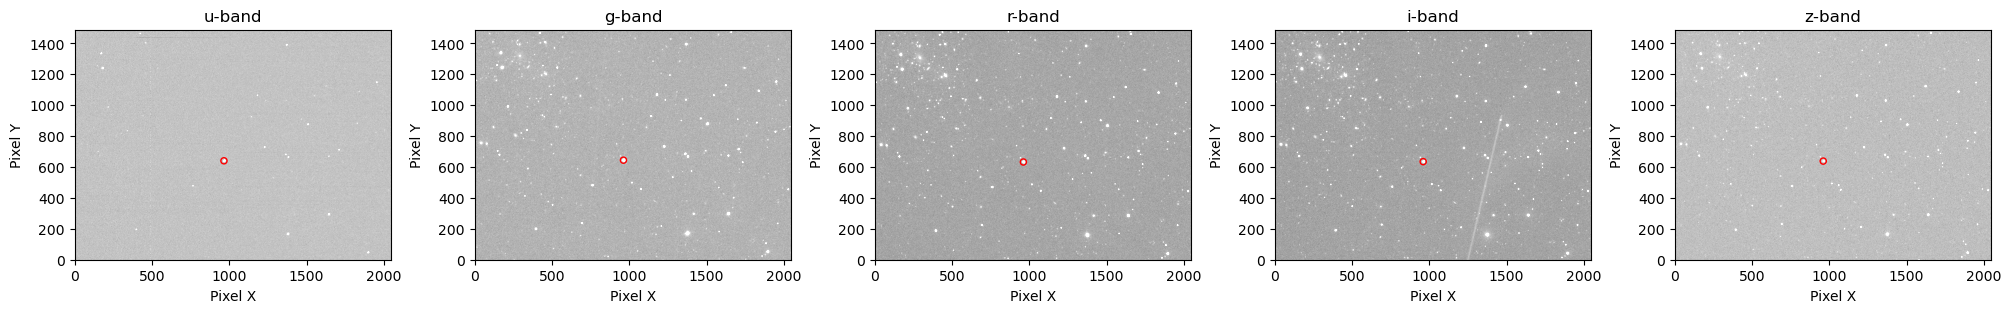

In [48]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import PercentileInterval, AsinhStretch, ImageNormalize

# Reference image and pixel position
ref_band = "r"
ref_file = "data/frame-r-007784-2-0257.fits"
ref_position = (961.2081628457288, 631.8924039577129)  # (x, y) in r-band

# All filter files
filter_files = {
    "u": "data/frame-u-007784-2-0257.fits",
    "g": "data/frame-g-007784-2-0257.fits",
    "r": ref_file,
    "i": "data/frame-i-007784-2-0257.fits",
    "z": "data/frame-z-007784-2-0257.fits"
}

# Step 1: Get sky coordinate of source in r-band
with fits.open(ref_file) as ref_hdul:
    ref_wcs = WCS(ref_hdul[0].header)
    sky_coord = ref_wcs.pixel_to_world(ref_position[0], ref_position[1])

# Step 2: Plot each image and mark the source position with a hollow red circle
fig, axs = plt.subplots(1, 5, figsize=(20, 4), constrained_layout=True)

for i, (band, file) in enumerate(filter_files.items()):
    with fits.open(file) as hdul:
        data = hdul[0].data
        wcs = WCS(hdul[0].header)

        # Normalize and stretch for better contrast
        norm = ImageNormalize(data, interval=PercentileInterval(99.5), stretch=AsinhStretch())

        # Convert sky coord to pixel in this band
        x, y = wcs.world_to_pixel(sky_coord)

        ax = axs[i]
        ax.imshow(data, origin='lower', cmap='gray', norm=norm)

        # Hollow red circle with radius 7 pixels
        circ = Circle((x, y), radius=20, edgecolor='red', facecolor='none', linewidth=1)
        ax.add_patch(circ)

        ax.set_title(f"{band}-band")
        ax.set_xlabel('Pixel X')
        ax.set_ylabel('Pixel Y')

plt.show()


In [53]:
from astropy.io import fits
from astropy.wcs import WCS

# Your original reference position (in pixels on r-band)
ref_position = (961.2081628457288, 631.8924039577129)
frame_id = "007784-2-0257"
filters = ['u', 'g', 'r', 'i', 'z']

# Step 1: Get sky coordinate from the r-band image at the reference position
ref_filename = f"data/frame-r-{frame_id}.fits"
with fits.open(ref_filename) as ref_hdul:
    ref_wcs = WCS(ref_hdul[0].header)
    sky_coord = ref_wcs.pixel_to_world(ref_position[0], ref_position[1])

print(f"Measuring flux at sky coordinate (from r-band): {sky_coord}\n")

# Step 2: For each filter, convert sky coord back to pixel in that filter, then measure flux
for f in filters:
    filename = f"data/frame-{f}-{frame_id}.fits"
    with fits.open(filename) as hdul:
        wcs = WCS(hdul[0].header)
        # Get pixel coordinate in current filter image from sky coord
        x, y = wcs.world_to_pixel(sky_coord)

        # Round to nearest pixel as integer, or keep float if measure_flux accepts float
        position = (x, y)

        print(f"Filter: {f.upper()} - Pixel position: ({x:.2f}, {y:.2f})")

        # Call your existing measure_flux with the updated position
        result = measure_flux(filename, position)
        for k, v in result.items():
            if isinstance(v, float):
                print(f"  {k}: {v:.4f}")
            else:
                print(f"  {k}: {v}")
        print()


Measuring flux at sky coordinate (from r-band): <SkyCoord (ICRS): (ra, dec) in deg
    (9.20464377, 9.23153266)>

Filter: U - Pixel position: (964.91, 639.81)
  Raw Flux (counts): 281.3073
  Background-subtracted Flux (counts): 279.1207
  Flux (nMgy): 3.8911
  Flux (mJy): 0.0000
  AB Magnitude: 21.0248

Filter: G - Pixel position: (961.68, 643.67)
  Raw Flux (counts): 815.5807
  Background-subtracted Flux (counts): 811.5785
  Flux (nMgy): 3.7337
  Flux (mJy): 0.0000
  AB Magnitude: 21.0696

Filter: R - Pixel position: (961.21, 631.89)
  Raw Flux (counts): 1205.7418
  Background-subtracted Flux (counts): 1199.4946
  Flux (nMgy): 6.5702
  Flux (mJy): 0.0000
  AB Magnitude: 20.4561

Filter: I - Pixel position: (960.02, 634.32)
  Raw Flux (counts): 1404.2507
  Background-subtracted Flux (counts): 1395.2299
  Flux (nMgy): 8.9370
  Flux (mJy): 0.0000
  AB Magnitude: 20.1220

Filter: Z - Pixel position: (960.29, 637.83)
  Raw Flux (counts): 1436.4997
  Background-subtracted Flux (counts): 142